# SWM mMPC & UMAP

### Libraries

In [3]:
import os
import glob
import nibabel as nb
import scipy.stats
from scipy import stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask
from brainspace.gradient.utils import dominant_set

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# libraries
import numpy as np
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.mesh.mesh_creation import build_polydata
import copy
from brainstat.datasets import fetch_mask
import matplotlib.cm as cm
import scipy as sp
import cmocean
from scipy.stats import spearmanr
from scipy.stats import pearsonr

ModuleNotFoundError: No module named 'brainspace'

### Functions

In [2]:
def inflate_surf(orig_lh, orig_rh, ref_lh, ref_rh, W=0.15):
    """
    This functions inflates a surface a determined amount [W{0:1}] to a reference
    
    Parameters
    ----------
        orig_lh : vtkPolyData or VTKObjectWrapper
                    left input original surface
        orig_rh : vtkPolyData or VTKObjectWrapper
                    right input original surface
        ref_lh  : vtkPolyData or VTKObjectWrapper
                    left input reference surface
        ref_rh  : vtkPolyData or VTKObjectWrapper
                    right input reference surface
        W       : float value from 0 to 1
        
    Returns
    -------
        new_lh : vtkPolyData or VTKObjectWrapper
                    left output inflated surface
        new_rh : vtkPolyData or VTKObjectWrapper
                    right output inflated surface
        
    """
    def inflate(orig, ref, Winf):
        # Convert BSPolyData objects to numpy arrays
        inf_coord = copy.copy(orig.points)
        inf_triag = copy.copy(orig.GetCells2D())
        
        # Inflated mean surface
        maxs = np.max(orig.points, axis=0)
        mins = np.min(orig.points, axis=0)
        maxsp = np.max(ref.points, axis=0)
        minsp = np.min(ref.points, axis=0)
        
        for i in range(3):
            inf_coord[:,i] = (((ref.points[:, i] - minsp[i]) / (maxsp[i] - minsp[i]))
                                 * (maxs[i] - mins[i]) + mins[i]) * Winf + orig.points[:, i] * (1 - Winf)
        
        # Create the new surface
        new_surf = build_polydata(inf_coord, cells=inf_triag)
        
        return(new_surf)
    
    new_lh = inflate(orig_lh, ref_lh, Winf=W)
    new_rh = inflate(orig_rh, ref_rh, Winf=W)
    
    return(new_lh, new_rh)

# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf, Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)

### Variables

In [16]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

inf32_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Load spheres fsLR5k
sphere_lh = read_surface(micapipe+'/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
sphere_rh = read_surface(micapipe+'/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')

# load stuff
mask_32k = load_mask(join=True)
mask_surf32 = mask_32k != 0

# Inflate the INFLATED surface 10% reference to the sphere
ws_lh, ws_rh = inflate_surf(MNI_wmL, MNI_wmR, sphere_lh, sphere_rh, W=0.1)

# Labels and boolean mask
mask_surf = mask_5k != 0

# Inflated fsLR-5k surfaces
inf5_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf5_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# Load fsaverage5
fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.pial', itype='fs')
fs5_mask = fetch_mask("fsaverage5")

## Microstructural profile by SWM depth

In [4]:
def load_qmri_intensity(qmri='', verbose=False):

    # Load CSV file containing subject and session information
    csv_dir = '/data/mica1/03_projects/youngeun/lists'
    csv_file = f"10PNC_{qmri}.csv"
    subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

    # Extract subject and session information from each row
    files = []
    for index, row in subject_session_info.iterrows():
        info = row['info'].split(',')
        subject = index[4:]  # Extract subject ID
        session = info[0][4:].strip()  # Extract session ID
        file_path = f"sub-{subject}/ses-{session}/mpc-swm/acq-{qmri}/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii"
        files.extend(glob.glob(file_path))
    
    # Print the file paths
    if verbose == True:
        print("Files used:")
        for file_path in files:
            print(file_path)

    # Load intensity profiles from each file
    profiles = []
    for file_path in files:
        profile_data = nb.load(file_path).darrays[0].data
        # Smooth each intensity
        profile_data_i = smooth_intensities(profile_data)
        # Replace values in midwall with NaN where mask_10k is False
        profile_data_i[:, mask_5k == False] = np.nan
        #profile_data_i = profile_data_i[1:]
        profiles.append(profile_data_i)
    
    profiles = np.array(profiles)

    # Extract subject and session information
    subjects = set()
    for file_path in files:
        parts = file_path.split('/')
        subject = parts[0][4:]  # Extract subject ID from the directory name
        subjects.add(subject)

    print(f"Intensity Profiles of {qmri} maps - Number of subjects: {len(subjects)}")

    return profiles

def process_qmri_profiles():
    # List of qmri values
    qmri_values = ['T1map', 'MTSAT_protocol', 'FA', 'ODI']
    
    # Initialize variables to store each matrix
    T1map = None
    MTSAT = None
    T2star = None
    FA = None
    fod_tournier_afd = None

    # Load data and store matrices for each qmri value
    for qmri in qmri_values:
        # Load intensity profiles for the given qmri value
        profiles = load_qmri_intensity(qmri)
        # Store the matrix
        if qmri == 'T1map':
            T1map = profiles
        elif qmri == 'MTSAT_protocol':
            MTSAT = profiles
        elif qmri == 'T2star':
            T2star = profiles
        elif qmri == 'FA':
            FA = profiles
        elif qmri == 'FOD':
            fod_tournier_afd = profiles
        elif qmri == 'ODI':
            ODI = profiles

    return T1map, MTSAT, T2star, FA, fod_tournier_afd, ODI

## Load intensity profiles

In [5]:
# Call the function to load profiles for each qmri value and store them as matrices
T1map, MTSAT, T2star, FA, FOD, ODI = process_qmri_profiles()
# Check the size of each matrix
print(f"T1map: {T1map.shape}")
print(f"MTSAT: {MTSAT.shape}")
print(f"FA: {FA.shape}")
print(f"ODI: {ODI.shape}")

Intensity Profiles of T1map maps - Number of subjects: 10
Intensity Profiles of MTSAT_protocol maps - Number of subjects: 10
Intensity Profiles of FA maps - Number of subjects: 10
Intensity Profiles of ODI maps - Number of subjects: 10
T1map: (10, 16, 9684)
MTSAT: (10, 16, 9684)
FA: (10, 16, 9684)
ODI: (10, 16, 9684)


## Average Intensity Profies

In [6]:
## Average Intensity Profies
# Calculate mean matrix for each dataset

mean_T1map = T1map = np.mean(T1map, axis=0)
mean_MTSAT = np.mean(MTSAT, axis=0)
mean_FA = np.mean(FA, axis=0)
mean_ODI = np.mean(ODI, axis=0)

# Check the shape of mean matrices
print(f"Mean T1map matrix shape: {mean_T1map.shape}")
print(f"Mean MTSAT matrix shape: {mean_MTSAT.shape}")
print(f"Mean FA matrix shape: {mean_FA.shape}")
print(f"Mean ODI matrix shape: {mean_ODI.shape}")

# Create R1
mean_R1 = 1/mean_T1map * 100

Mean T1map matrix shape: (16, 9684)
Mean MTSAT matrix shape: (16, 9684)
Mean FA matrix shape: (16, 9684)
Mean ODI matrix shape: (16, 9684)



## Normalise Intensity Profiles

### Min-Max normalization

In [7]:
def rescale_data(data, mask, demean=False, lq=0.001, hq=0.999):
    # masked data to calculate the min max and mean without the medial wall mask
    masked_data = data[:, mask==True]    
    #min_data = np.min(masked_data)
    #max_data = np.max(masked_data)
    min_data = np.nanquantile(masked_data, lq)
    max_data = np.nanquantile(masked_data, hq)
    
    #  rescale from 0 to 1 the dta
    norm_data = ((data - min_data) / (max_data - min_data))

    # DE MEAN THE DATA
    if demean == True:
        norm_datamasked = norm_data[:, mask==True]    
        mean_data = np.mean(norm_datamasked[~np.isnan(norm_datamasked)])
        norm_data = norm_data - mean_data
        
    return (norm_data)

def calculate_mode(data):
    unique_values, counts = np.unique(data, return_counts=True)
    max_count_index = np.argmax(counts)
    mode_value = unique_values[max_count_index]
    return(mode_value)

def get_mode(Array, sicpy=False):
    
    # Flatten the array
    array_flat  = Array.flatten()

    # Identify rows with NaN values and exclude them
    data_sliced = array_flat[~np.isnan(array_flat)]

    if sicpy == False:
        # Calculate mode
        mode_value = calculate_mode(data_sliced)
    else:
        # Scipy mode
        mode_value = stats.mode(data_sliced)[0][0]

    return(np.mean(Array))
    #return mode_value

def normalization_mode(Array, mask, sicpy=False):
    # Mode of the white matter surface
    data_mode = get_mode(Array[15:16, mask==True], sicpy=False)
    print(data_mode)
    
    # Difference from 1
    #mode_diff = np.abs(1 - data_mode)
    
    # Center based on the white matter surface mode
    #norm_data = Array - data_mode / mode_diff
    norm_data = Array - data_mode
    
    return (norm_data)

def slice_array(data, mask):
    data[:, mask == False] = np.nan

    # Identify rows with NaN values and exclude them
    valid_rows = ~np.isnan(data).any(axis=0)
    data_sliced = data[:, valid_rows]
    return (data_sliced)

def plot_histogram(data, bins=2000, title='Histogram', cmap='afmhot', Range=(0, 2500),
                   xlim=[0,2500], ylim=2000, mode_value=None, val2=None):
    non_zero_values = data[data != 0]
    n, bins, _ = plt.hist(non_zero_values, bins=bins, color='blue', alpha=0.7)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
    
    colormap = cm.get_cmap(cmap)
    colored_bins = colormap(np.interp(bin_centers, [Range[0], Range[1]], [0, 1]))
    plt.bar(bin_centers, n, width=np.diff(bin_centers[0:2]), color=colored_bins)
    
    plt.title(title)
    #plt.xlabel('Intensity Value')
    #plt.ylabel('Frequency')

    # Remove the outer box line
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Set the grid on the back
    plt.gca().set_axisbelow(True)
    plt.grid(color='gray', linestyle='dashed')

    # Plot a vertical line at the mode value
    if mode_value is not None:
        plt.axvline(x=mode_value[0], color='blue', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[0]}')
        plt.axvline(x=mode_value[1], color='green', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[1]}')
    if val2 is not None:
        plt.axvline(x=val2, color='white', linestyle='dashed', linewidth=2, label=f'ModeMRtrix = {val2}')
    
    plt.legend()
    
    # Set x-axis range (adjust as needed)
    plt.xlim(xlim)

    # Set y-axis range (adjust as needed)
    plt.ylim([0, ylim])
    
    plt.show()


/tmp/ipykernel_2057641/950208776.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


2024-06-11 20:07:58,902 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


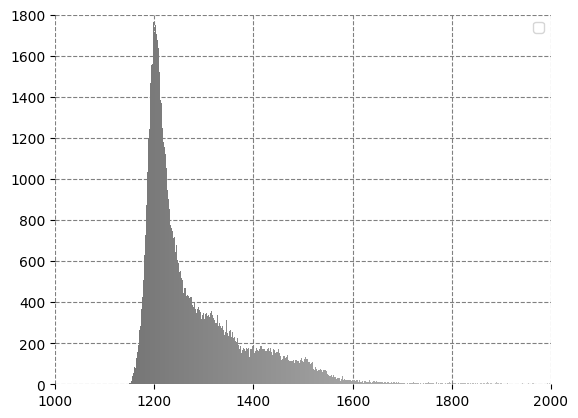

In [117]:
plot_histogram(mean_T1map, bins=1000, title='', cmap='gray', xlim=(1000,2000), ylim=1800, mode_value=None, val2=None)

/tmp/ipykernel_2057641/950208776.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


2024-06-11 20:08:01,159 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


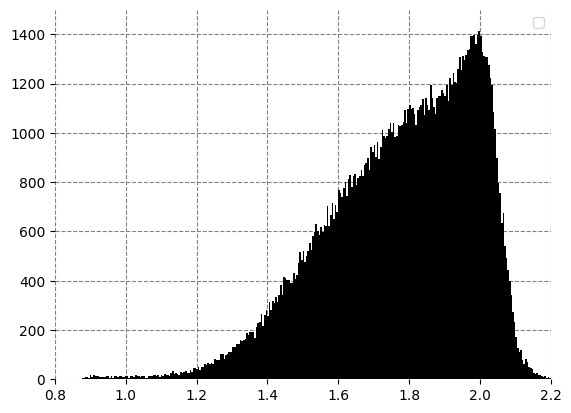

In [118]:
plot_histogram(mean_MTSAT[~np.isnan(mean_MTSAT)], bins=300, title='', cmap='gray', xlim=(0.8,2.2), ylim=1500, mode_value=None, val2=None)

In [119]:
print('MEAN: '+ str(np.mean(mean_T1map[~np.isnan(mean_T1map)])))
print('q0.25: '+ str(np.quantile(mean_T1map[~np.isnan(mean_T1map)],0.001)))
print('q0.25: '+ str(np.quantile(mean_T1map[~np.isnan(mean_T1map)],0.999)))

MEAN: 1282.3389
q0.25: 1157.9585528564453
q0.25: 1993.9634924316404


In [120]:
print('MEAN: '+ str(np.mean(mean_MTSAT[~np.isnan(mean_MTSAT)])))
print('q0.25: '+ str(np.quantile(mean_MTSAT[~np.isnan(mean_MTSAT)],0.001)))
print('q0.25: '+ str(np.quantile(mean_MTSAT[~np.isnan(mean_MTSAT)],0.999)))

MEAN: 1.7778827
q0.25: 0.9287684139609337
q0.25: 2.1570725715160344


# Quantile rescaling

In [10]:
qT1map = copy.deepcopy(mean_T1map)
qMTSAT = copy.deepcopy(mean_MTSAT)
qR1 = copy.deepcopy(mean_R1)

qT1map = rescale_data(mean_T1map, mask_5k, demean=False, lq=0.001, hq=0.999)
qMTSAT = rescale_data(mean_MTSAT, mask_5k, demean=False, lq=0.001, hq=0.999)
qR1 = rescale_data(mean_R1, mask_5k, demean=False, lq=0.001, hq=0.999)


/tmp/ipykernel_2057641/950208776.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


2024-06-11 20:08:52,795 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


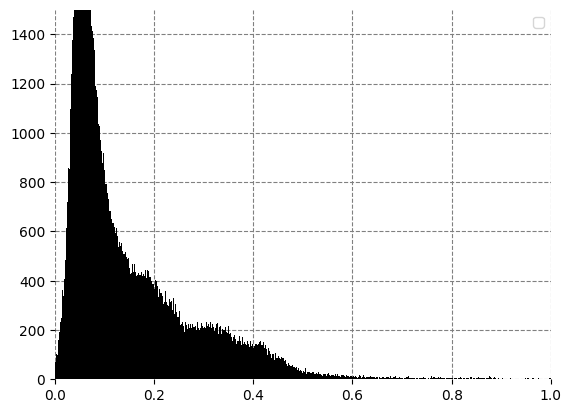

In [124]:
plot_histogram(qT1map[~np.isnan(mean_T1map)], bins=800, title='', cmap='gray', xlim=(0,1), ylim=1500, mode_value=None, val2=None)

/tmp/ipykernel_2057641/2404037881.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


2024-06-12 03:19:02,902 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


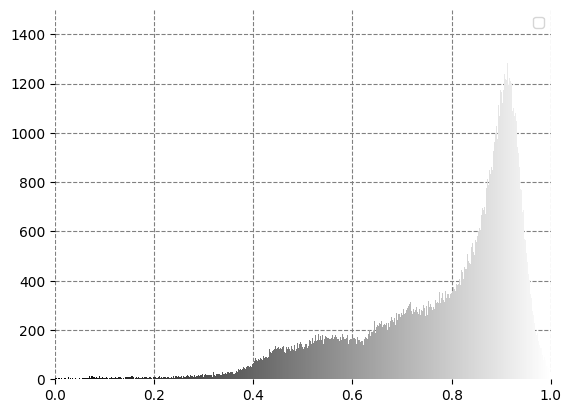

In [210]:
plot_histogram(qR1[~np.isnan(mean_R1)], bins=800, title='', cmap='gray', xlim=(0,1), ylim=1500, mode_value=None, val2=None, Range=xlim)

/tmp/ipykernel_2057641/2404037881.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


2024-06-12 03:19:27,773 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


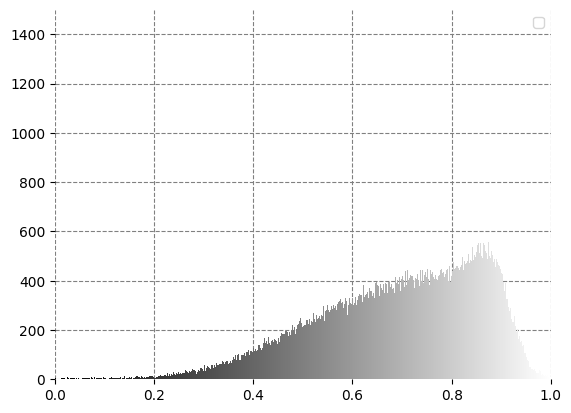

In [211]:
plot_histogram(qMTSAT[~np.isnan(qMTSAT)], bins=800, title='', cmap='gray', xlim=(0,1), ylim=1500, mode_value=None, val2=None, Range=xlim)

# Quantile rescaling and Mode centering

In [11]:
mR1 = normalization_mode(qR1, mask_5k, sicpy=False)
mT1map = normalization_mode(qT1map, mask_5k, sicpy=False)
mMTSAT = normalization_mode(qMTSAT, mask_5k, sicpy=False)

0.46452832
0.40369025
0.4439822


2024-06-12 03:58:20,605 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_2057641/2404037881.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


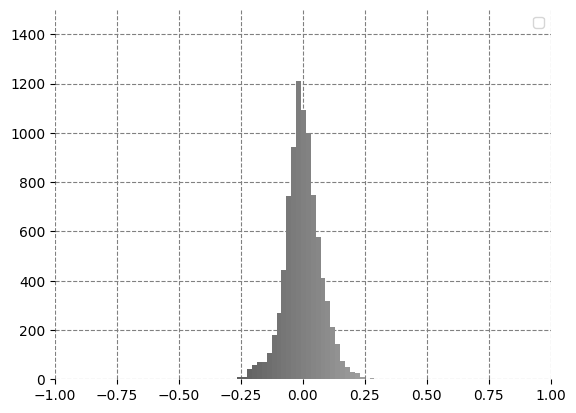

In [227]:
plot_histogram(mR1[15:16], bins=30, title='', cmap='gray', xlim=(-1,1), ylim=1500, mode_value=None, val2=None, Range=xlim)

2024-06-12 03:58:34,041 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_2057641/2404037881.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


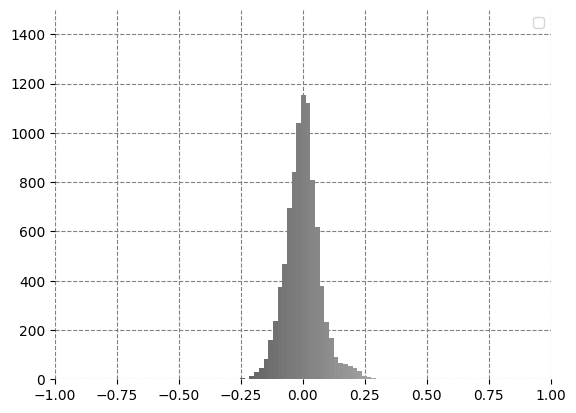

In [228]:
plot_histogram(mT1map[15:16], bins=30, title='', cmap='gray', xlim=(-1,1), ylim=1500, mode_value=None, val2=None, Range=xlim)

2024-06-12 03:59:12,170 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_2057641/2404037881.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


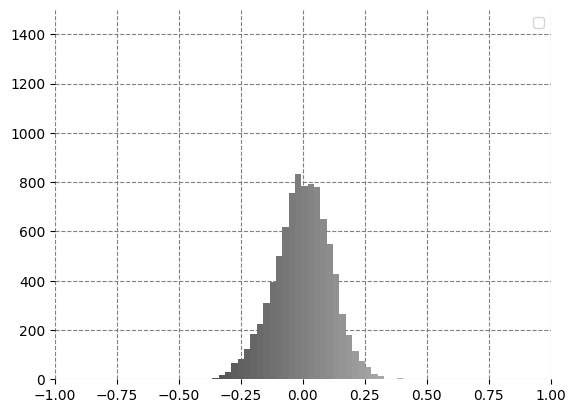

In [229]:
plot_histogram(mMTSAT[15:16], bins=30, title='', cmap='gray', xlim=(-1,1), ylim=1500, mode_value=None, val2=None, Range=xlim)

/tmp/ipykernel_2057641/2404037881.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


2024-06-12 03:23:50,453 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


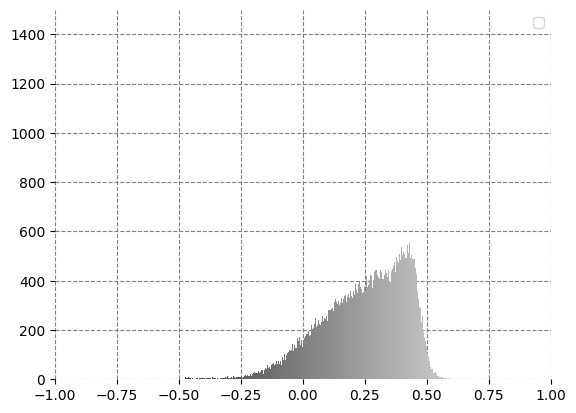

In [217]:
plot_histogram(mMTSAT[~np.isnan(mMTSAT)], bins=800, title='', cmap='gray', xlim=(-1,1), ylim=1500, mode_value=None, val2=None, Range=xlim)

/tmp/ipykernel_2057641/2404037881.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


2024-06-12 03:23:53,136 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


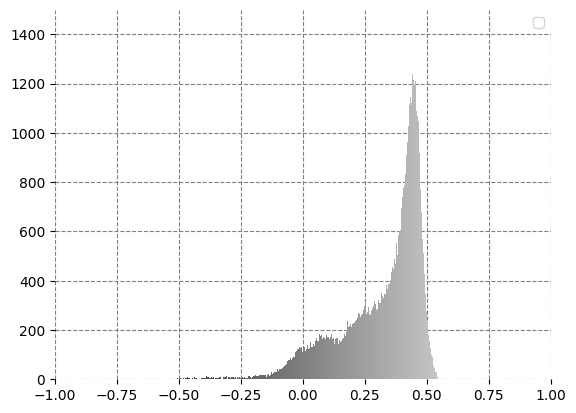

In [218]:
plot_histogram(mR1[~np.isnan(mR1)], bins=800, title='', cmap='gray', xlim=(-1,1), ylim=1500, mode_value=None, val2=None, Range=xlim)

/tmp/ipykernel_2057641/2404037881.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


2024-06-11 20:30:15,456 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


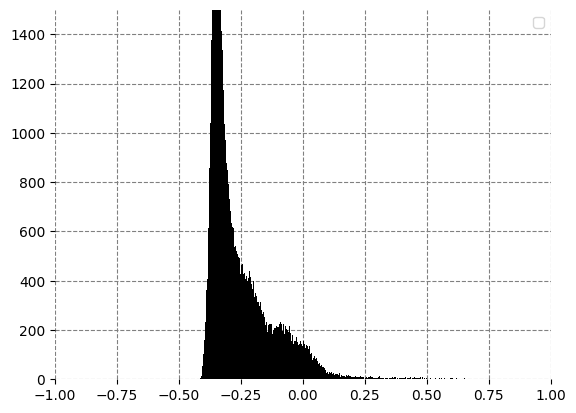

In [167]:
plot_histogram(mT1map[~np.isnan(mT1map)], bins=800, title='', cmap='gray', xlim=(-1,1), ylim=1500, mode_value=None, val2=None)

In [13]:
# Sliced the concatenated array
concat_norm = np.concatenate((mR1.T, mMTSAT.T), axis=1)
concat_norm_sliced = slice_array(np.flip(concat_norm.T), mask_5k)

In [ ]:
# Adjust the figure size as per your requirement
plt.figure(figsize=(15, 8))  # Adjust the values (width, height) as needed

# COlor range
xlim = [-1,1]

# Plot the pcolormesh
pcm = plt.pcolormesh(concat_norm_sliced, cmap='gray', shading='auto', vmin = xlim[0], vmax = xlim[1])

# Set labels
#plt.xlabel('Vertices')
plt.xticks([])
plt.yticks([])  # Remove y-axis labels

cbar = plt.colorbar(pcm)

plt.show()

# mMPC calculation

In [12]:
import os
import glob
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_5k != 0

# Environment variables
surf='fsLR-5k'
out_maps='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/noFA_SWM'
out_surf='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/I_figured_out_SWM/rawdata/micapipe_v0.2.0/sub-MNI152/surf'

# Load MNI white matter surface
MNI_wmL = read_surface(f'{out_surf}/sub-MNI152_hemi-L_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')
MNI_wmR = read_surface(f'{out_surf}/sub-MNI152_hemi-R_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')

# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, kernel=None, sparsity=0.9):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=sparsity)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        grad[i] = g_nan
    
    return (MPCgm, grad)

def _build_kernel(x, kernel, gamma=None):

    if kernel in {'pearson', 'spearman'}:
        if kernel == 'spearman':
            x = np.apply_along_axis(rankdata, 1, x)
        return np.corrcoef(x)

    if kernel in {'cosine', 'normalized_angle'}:
        x = 1 - squareform(pdist(x, metric='cosine'))
        if kernel == 'normalized_angle':
            x = 1 - np.arccos(x, x)/np.pi
        return x

    if kernel == 'gaussian':
        if gamma is None:
            gamma = 1 / x.shape[1]
        return rbf_kernel(x, gamma=gamma)

    if callable(kernel):
        return kernel(x)

    raise ValueError("Unknown kernel '{0}'.".format(kernel))

def compute_affinity(x, kernel=None, sparsity=.9, pre_sparsify=True,
                     non_negative=True, gamma=None):
    """Compute affinity matrix.

    Parameters
    ----------
    x : ndarray, shape = (n_samples, n_feat)
        Input matrix.
    kernel : str, None or callable, optional
        Kernel function. If None, only sparsify. Default is None.
        Valid options:

        - If 'pearson', use Pearson's correlation coefficient.
        - If 'spearman', use Spearman's rank correlation coefficient.
        - If 'cosine', use cosine similarity.
        - If 'normalized_angle': use normalized angle between two vectors. This
          option is based on cosine similarity but provides similarities
          bounded between 0 and 1.
        - If 'gaussian', use Gaussian kernel or RBF.

    sparsity : float or None, optional
        Proportion of smallest elements to zero-out for each row.
        If None, do not sparsify. Default is 0.9.
    pre_sparsify : bool, optional
        Sparsify prior to building the affinity. If False, sparsify the final
        affinity matrix.
    non_negative : bool, optional
        If True, zero-out negative values. Otherwise, do nothing.
    gamma : float or None, optional
        Inverse kernel width. Only used if ``kernel == 'gaussian'``.
        If None, ``gamma = 1./n_feat``. Default is None.

    Returns
    -------
    affinity : ndarray, shape = (n_samples, n_samples)
        Affinity matrix.
    """

    # Do not accept sparse matrices for now
    if sp.issparse(x):
        x = x.toarray()

    if not pre_sparsify and kernel is not None:
        x = _build_kernel(x, kernel, gamma=gamma)

    if sparsity is not None and sparsity > 0:
        x = dominant_set(x, k=1-sparsity, is_thresh=False, as_sparse=False)

    if pre_sparsify and kernel is not None:
        x = _build_kernel(x, kernel, gamma=gamma)

    if non_negative:
        x[x < 0] = 0

    return x

## Compute mMPC: Only quantile rescaled

In [190]:
# Concatenated the data NO mask NO slice
concat_norm = np.concatenate((qT1map.T, qMTSAT.T), axis=1)
concat_norm_sliced = slice_array(np.flip(concat_norm.T), mask_5k)

In [191]:
mMPC = build_mpc(concat_norm.T, mask_surf) # compute mMPC

/tmp/ipykernel_2057641/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


In [15]:
# Calculate the gradients
Ngrad=3
MPC_all, grad_mMPC = mpc_dm(mMPC, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# Inflate the INFLATED surface 10% reference to the sphere
ws_lh, ws_rh = inflate_surf(MNI_wmL, MNI_wmR, sphere_lh, sphere_rh, W=0.1)

NameError: name 'mMPC' is not defined

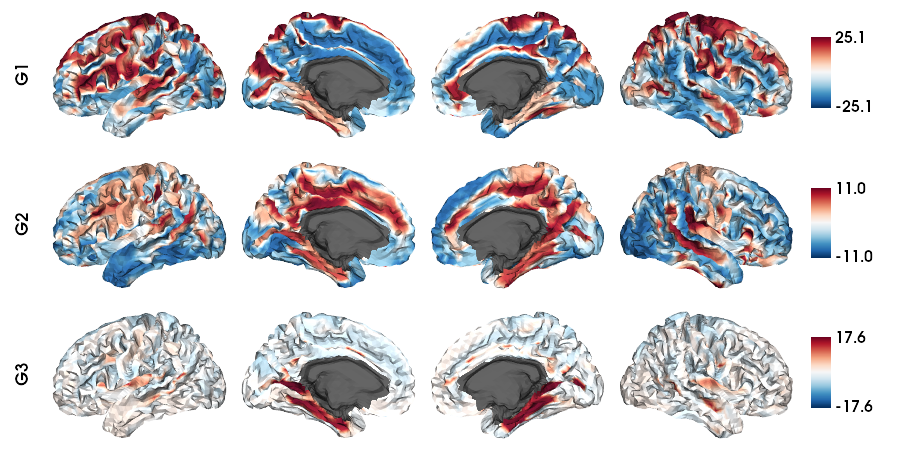

In [193]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(ws_lh, ws_rh, array_name=grad_mMPC, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [206]:
# Concatenated the data NO mask NO slice
concat_norm = np.concatenate((qR1.T, qMTSAT.T), axis=1)
concat_norm_sliced = slice_array(np.flip(concat_norm.T), mask_5k)

/tmp/ipykernel_2057641/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


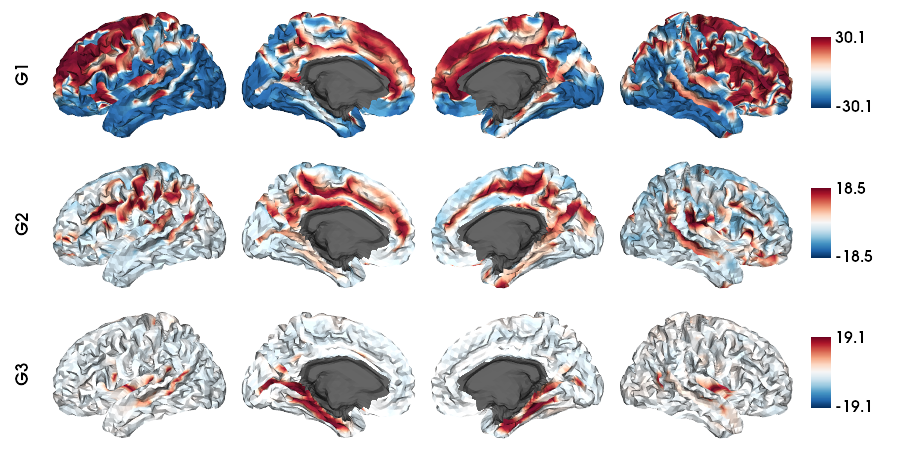

In [195]:
mMPC = build_mpc(concat_norm.T, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=3
MPC_all, grad_mMPC = mpc_dm(mMPC, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(ws_lh, ws_rh, array_name=grad_mMPC, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## Compute mMPC: Quantile rescaled AND demeaned

In [196]:
# Concatenated the data NO mask NO slice
concat_norm = np.concatenate((mT1map.T, mMTSAT.T), axis=1)
concat_norm_sliced = slice_array(np.flip(concat_norm.T), mask_5k)

/tmp/ipykernel_2057641/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


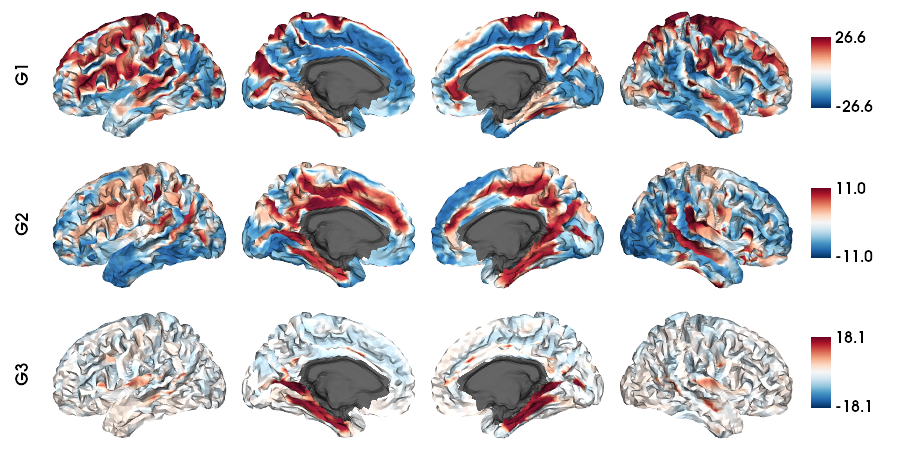

In [197]:
mMPC = build_mpc(concat_norm.T, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=3
MPC_all, grad_mMPC = mpc_dm(mMPC, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(ws_lh, ws_rh, array_name=grad_mMPC, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [234]:
# Concatenated the data NO mask NO slice
concat_norm = np.concatenate((mR1.T, mMTSAT.T), axis=1)
concat_norm_sliced = slice_array(np.flip(concat_norm.T), mask_5k)

/tmp/ipykernel_2057641/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


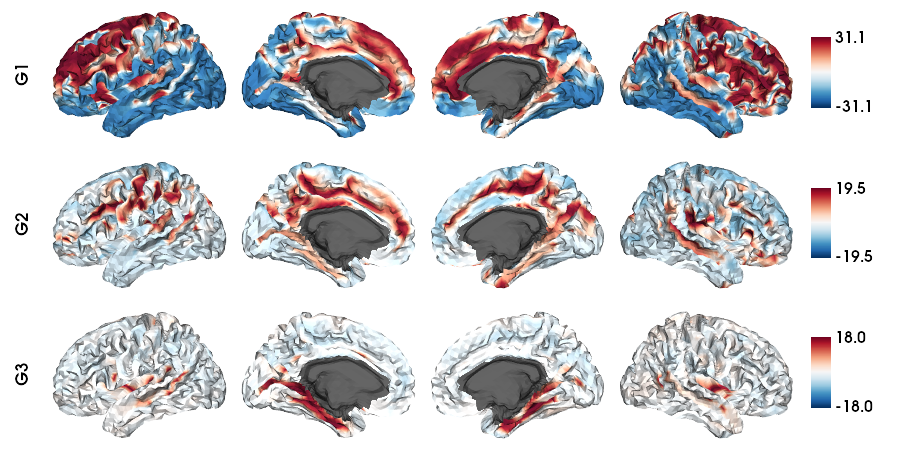

In [235]:
mMPC = build_mpc(concat_norm.T, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=3
MPC_all, grad_mMPC = mpc_dm(mMPC, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(ws_lh, ws_rh, array_name=grad_mMPC, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [236]:
np.save('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_SWM_G1_T1map_MTSAT.npy', grad_mMPC[0])

# MPC R1

In [14]:
MPC_T1map = build_mpc(qT1map, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=3
MPC_all, grad_T1map = mpc_dm(MPC_T1map, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(ws_lh, ws_rh, array_name=grad_T1map, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

/tmp/ipykernel_3740061/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


NameError: name 'ws_lh' is not defined

/tmp/ipykernel_3740061/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


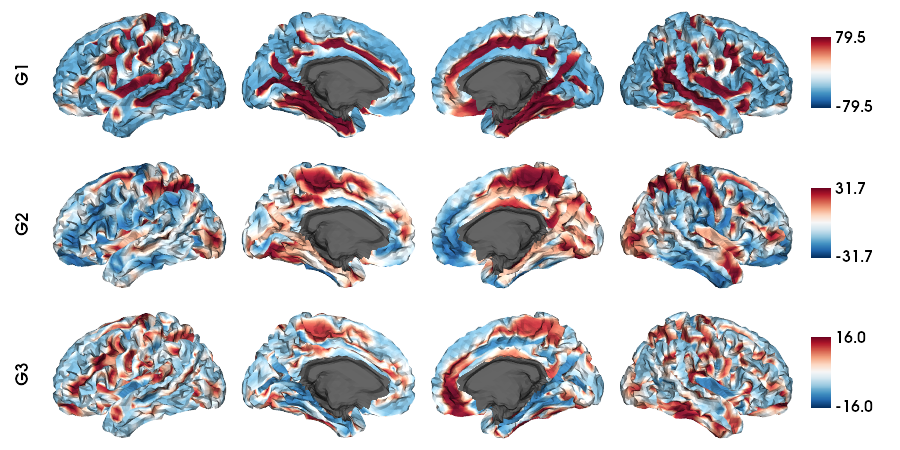

In [17]:
MPC_R1 = build_mpc(qR1, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=3
MPC_all, grad_R1 = mpc_dm(MPC_R1, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(ws_lh, ws_rh, array_name=grad_R1, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [19]:
np.save('/host/percy/local_raid/youngeun/myjupyter/array/R1_SWM.npy', grad_R1[0])

/tmp/ipykernel_3740061/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


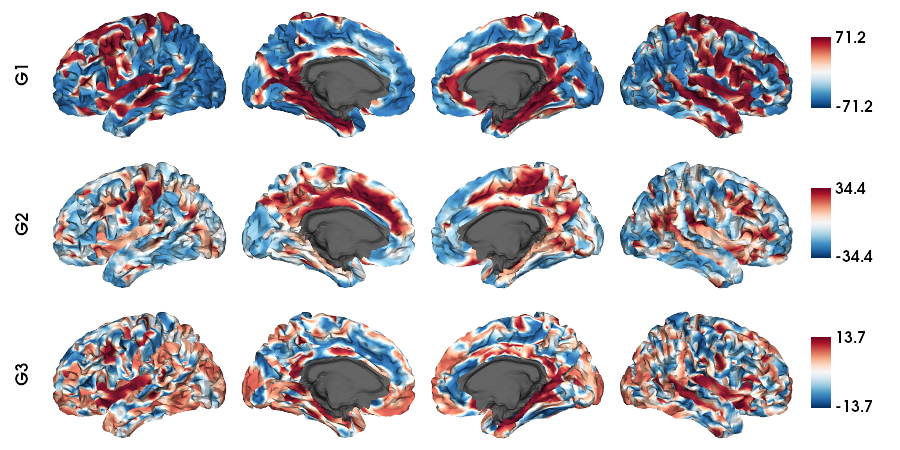

In [18]:
MPC_MTSAT = build_mpc(qMTSAT, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=3
MPC_all, grad_MTSAT = mpc_dm(MPC_MTSAT, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(ws_lh, ws_rh, array_name=grad_MTSAT, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [ ]:
np.save('/host/percy/local_raid/youngeun/myjupyter/array/MTSAT_SWM.npy', grad_R1[0])

In [17]:
np.save('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_5k_SWM_G1_old.npy', grad_mMPC[0])

In [231]:
from brainspace.gradient import GradientMaps

# Ask for 10 gradients (default)
gm = GradientMaps(n_components=10, random_state=0)
gm.fit(mMPC)

/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')
/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


GradientMaps(random_state=0)

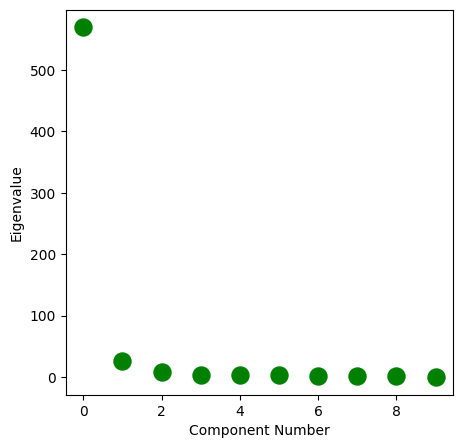

In [232]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_, s=150, c='green')
ax.set_xlabel('Component Number')
ax.set_ylabel('Eigenvalue')

plt.show()

## Blade-like atlas

In [36]:
# Environment variables
surf='fsLR-5k'
out_maps='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/noFA_SWM'
out_surf='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/I_figured_out_SWM/rawdata/micapipe_v0.2.0/sub-MNI152/surf'

# Load MNI white matter surface
MNI_wmL = read_surface(f'{out_surf}/sub-MNI152_hemi-L_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')
MNI_wmR = read_surface(f'{out_surf}/sub-MNI152_hemi-R_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')

# Load blade metric
bladesL =  nb.load(f'{out_maps}/MNI152_hemi-L_surf-{surf}_label-white_atlas-blades.shape.gii').darrays[0].data
bladesR =  nb.load(f'{out_maps}/MNI152_hemi-L_surf-{surf}_label-white_atlas-blades.shape.gii').darrays[0].data
blades = np.concatenate((bladesL, bladesR), axis=0)

### Resample the labels

In [37]:
for i in range(len(blades)):

    if blades[i] == 21:
        blades[i] = 1
    elif blades[i] == 23:
        blades[i] = 2
    elif blades[i] == 25 or blades[i] == 29 or blades[i] == 31 or blades[i] == 33:
        blades[i] = 3
    elif blades[i] == 27:
        blades[i] = 4
    elif blades[i] == 41:
        blades[i] = 5
    elif blades[i] == 43 or blades[i] == 49:
        blades[i] = 6
    elif blades[i] == 45 or blades[i] == 47 or blades[i] == 81:
        blades[i] = 7
    elif blades[i] == 61 or blades[i] == 63 or blades[i] == 65 or blades[i] == 67 or blades[i] == 89:
        blades[i] = 8
    elif blades[i] == 83 or blades[i] == 85 or blades[i] == 91 or blades[i] == 87:
        blades[i] = 9
    elif blades[i] == 101:
        blades[i] = 10
    elif blades [i] >= 103:
        blades[i] = 0

In [38]:
# Remove the medial wall
blades[blades==0]=np.NaN

# NaNing everything >= than 180
blades[blades>=160]=np.NaN

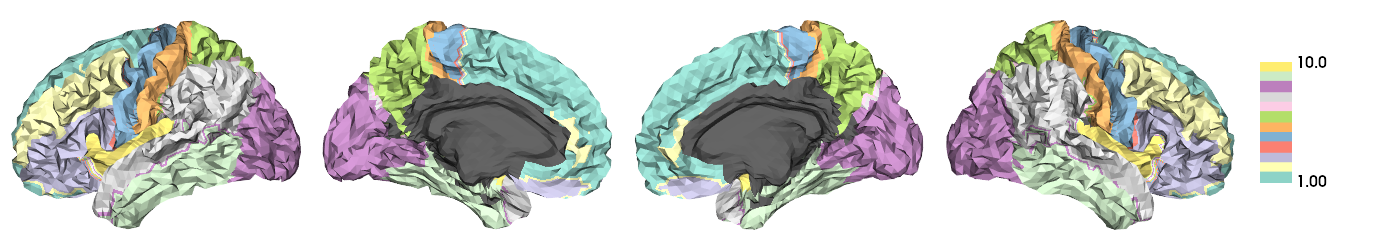

In [39]:
import cmocean

# plot labels on surface
plot_hemispheres(MNI_wmL, MNI_wmR, array_name=blades, size=(1400, 250), zoom=1.5, embed_nb=True, interactive=False, share='both',
                 nan_color=(0.3, 0.3, 0.3, 1), cmap='Set3', transparent_bg=True, color_bar='right')

### Plotting Ridge Graph (Sorted)

### T1map

In [40]:
import numpy as np
import pandas as pd
from easy_mpl import ridge
import matplotlib.pyplot as plt
from easy_mpl.utils import version_info

sG1 = grad_T1map[0] # G1 plotting

# Find indices where mesu_5k has values 1, 2, 3, and 4
indices_1 = np.where(blades == 1)[0]
indices_2 = np.where(blades == 2)[0]
indices_3 = np.where(blades == 3)[0]
indices_4 = np.where(blades == 4)[0]
indices_5 = np.where(blades == 5)[0]
indices_6 = np.where(blades == 6)[0]
indices_7 = np.where(blades == 7)[0]
indices_8 = np.where(blades == 8)[0]
indices_9 = np.where(blades == 9)[0]
indices_10 = np.where(blades == 10)[0]

# Extract values from sgrad corresponding to these indices
values_1 = sG1[indices_1]
values_2 = sG1[indices_2]
values_3 = sG1[indices_3]
values_4 = sG1[indices_4]
values_5 = sG1[indices_5]
values_6 = sG1[indices_6]
values_7 = sG1[indices_7]
values_8 = sG1[indices_8]
values_9 = sG1[indices_9]
values_10 = sG1[indices_10]

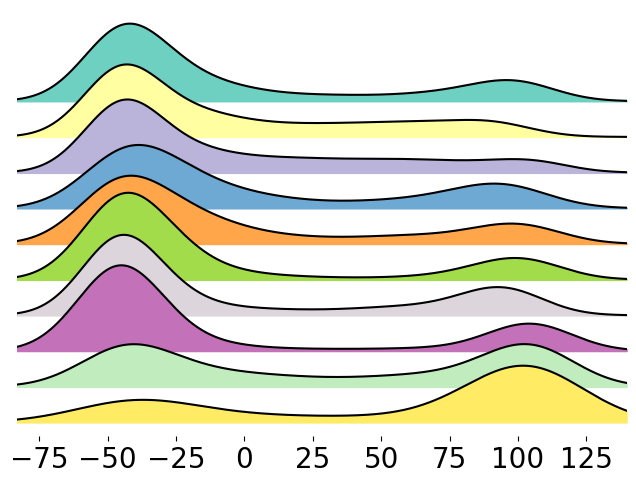

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy

custom4G1 = [(110/255, 208/255, 193/255),  # 1
            (255/255, 255/255, 162/255),  # 2
            (186/255, 179/255, 218/255),  # 3 
            (110/255, 169/255, 211/255),  # 4
            (255/255, 166/255, 74/255),   # 5
            (163/255, 220/255, 74/255),   # 6  
            (220/255, 213/255, 220/255),  # 7
            (195/255, 114/255, 186/255),  # 8
            (193/255, 237/255, 190/255),  # 9
            (255/255, 236/255, 100/255)]   # 10

# Sample data
df = [values_1, values_2, values_3, values_4, values_5, values_6, values_7, values_8, values_9, values_10]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

### MTSAT

In [47]:
import numpy as np
import pandas as pd
from easy_mpl import ridge
import matplotlib.pyplot as plt
from easy_mpl.utils import version_info

sG1 = grad_MTSAT[0] # G1 plotting

# Find indices where mesu_5k has values 1, 2, 3, and 4
indices_1 = np.where(blades == 1)[0]
indices_2 = np.where(blades == 2)[0]
indices_3 = np.where(blades == 3)[0]
indices_4 = np.where(blades == 4)[0]
indices_5 = np.where(blades == 5)[0]
indices_6 = np.where(blades == 6)[0]
indices_7 = np.where(blades == 7)[0]
indices_8 = np.where(blades == 8)[0]
indices_9 = np.where(blades == 9)[0]
indices_10 = np.where(blades == 10)[0]

# Extract values from sgrad corresponding to these indices
values_1 = sG1[indices_1]
values_2 = sG1[indices_2]
values_3 = sG1[indices_3]
values_4 = sG1[indices_4]
values_5 = sG1[indices_5]
values_6 = sG1[indices_6]
values_7 = sG1[indices_7]
values_8 = sG1[indices_8]
values_9 = sG1[indices_9]
values_10 = sG1[indices_10]

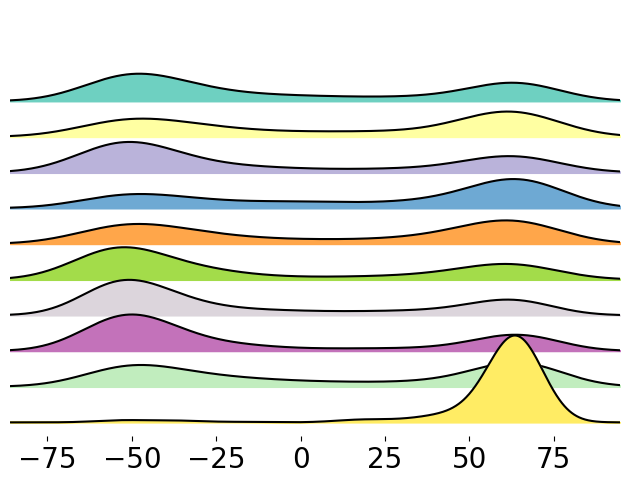

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy

custom4G1 = [(110/255, 208/255, 193/255),  # 1
            (255/255, 255/255, 162/255),  # 2
            (186/255, 179/255, 218/255),  # 3 
            (110/255, 169/255, 211/255),  # 4
            (255/255, 166/255, 74/255),   # 5
            (163/255, 220/255, 74/255),   # 6  
            (220/255, 213/255, 220/255),  # 7
            (195/255, 114/255, 186/255),  # 8
            (193/255, 237/255, 190/255),  # 9
            (255/255, 236/255, 100/255)]   # 10

# Sample data
df = [values_1, values_2, values_3, values_4, values_5, values_6, values_7, values_8, values_9, values_10]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

### FA

In [49]:
import numpy as np
import pandas as pd
from easy_mpl import ridge
import matplotlib.pyplot as plt
from easy_mpl.utils import version_info

sG1 = grad_FA[0] # G1 plotting

# Find indices where mesu_5k has values 1, 2, 3, and 4
indices_1 = np.where(blades == 1)[0]
indices_2 = np.where(blades == 2)[0]
indices_3 = np.where(blades == 3)[0]
indices_4 = np.where(blades == 4)[0]
indices_5 = np.where(blades == 5)[0]
indices_6 = np.where(blades == 6)[0]
indices_7 = np.where(blades == 7)[0]
indices_8 = np.where(blades == 8)[0]
indices_9 = np.where(blades == 9)[0]
indices_10 = np.where(blades == 10)[0]

# Extract values from sgrad corresponding to these indices
values_1 = sG1[indices_1]
values_2 = sG1[indices_2]
values_3 = sG1[indices_3]
values_4 = sG1[indices_4]
values_5 = sG1[indices_5]
values_6 = sG1[indices_6]
values_7 = sG1[indices_7]
values_8 = sG1[indices_8]
values_9 = sG1[indices_9]
values_10 = sG1[indices_10]

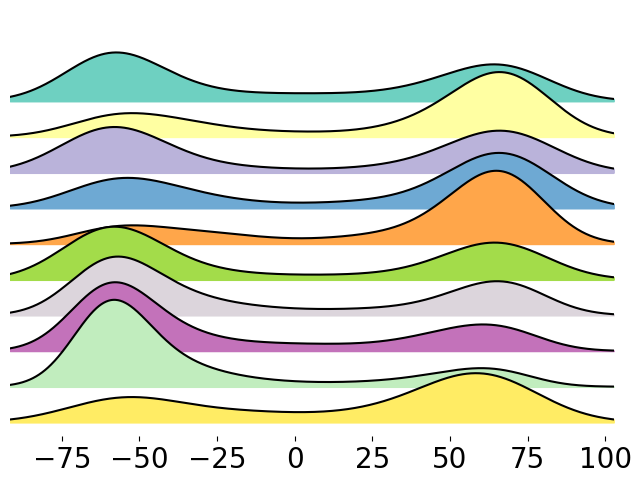

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy

custom4G1 = [(110/255, 208/255, 193/255),  # 1
            (255/255, 255/255, 162/255),  # 2
            (186/255, 179/255, 218/255),  # 3 
            (110/255, 169/255, 211/255),  # 4
            (255/255, 166/255, 74/255),   # 5
            (163/255, 220/255, 74/255),   # 6  
            (220/255, 213/255, 220/255),  # 7
            (195/255, 114/255, 186/255),  # 8
            (193/255, 237/255, 190/255),  # 9
            (255/255, 236/255, 100/255)]   # 10

# Sample data
df = [values_1, values_2, values_3, values_4, values_5, values_6, values_7, values_8, values_9, values_10]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

### ODI

In [57]:
import numpy as np
import pandas as pd
from easy_mpl import ridge
import matplotlib.pyplot as plt
from easy_mpl.utils import version_info

sG1 = grad_ODI[0] # G1 plotting

# Find indices where mesu_5k has values 1, 2, 3, and 4
indices_1 = np.where(blades == 1)[0]
indices_2 = np.where(blades == 2)[0]
indices_3 = np.where(blades == 3)[0]
indices_4 = np.where(blades == 4)[0]
indices_5 = np.where(blades == 5)[0]
indices_6 = np.where(blades == 6)[0]
indices_7 = np.where(blades == 7)[0]
indices_8 = np.where(blades == 8)[0]
indices_9 = np.where(blades == 9)[0]
indices_10 = np.where(blades == 10)[0]

# Extract values from sgrad corresponding to these indices
values_1 = sG1[indices_1]
values_2 = sG1[indices_2]
values_3 = sG1[indices_3]
values_4 = sG1[indices_4]
values_5 = sG1[indices_5]
values_6 = sG1[indices_6]
values_7 = sG1[indices_7]
values_8 = sG1[indices_8]
values_9 = sG1[indices_9]
values_10 = sG1[indices_10]

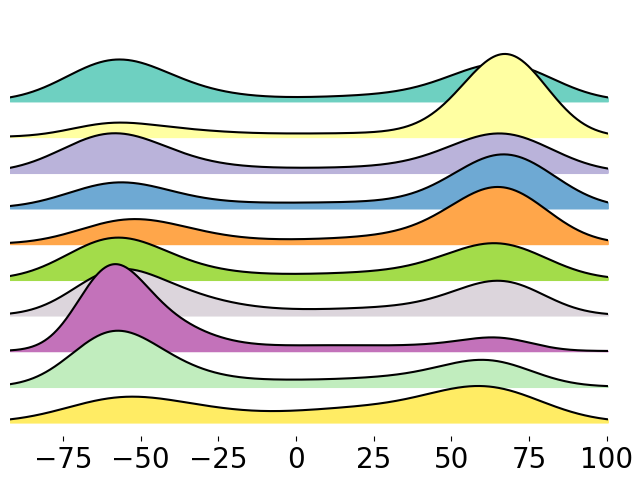

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy

custom4G1 = [(110/255, 208/255, 193/255),  # 1
            (255/255, 255/255, 162/255),  # 2
            (186/255, 179/255, 218/255),  # 3 
            (110/255, 169/255, 211/255),  # 4
            (255/255, 166/255, 74/255),   # 5
            (163/255, 220/255, 74/255),   # 6  
            (220/255, 213/255, 220/255),  # 7
            (195/255, 114/255, 186/255),  # 8
            (193/255, 237/255, 190/255),  # 9
            (255/255, 236/255, 100/255)]   # 10

# Sample data
df = [values_1, values_2, values_3, values_4, values_5, values_6, values_7, values_8, values_9, values_10]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

### mMPC

In [59]:
import numpy as np
import pandas as pd
from easy_mpl import ridge
import matplotlib.pyplot as plt
from easy_mpl.utils import version_info

sG1 = grad_mMPC[0] # G1 plotting

# Find indices where mesu_5k has values 1, 2, 3, and 4
indices_1 = np.where(blades == 1)[0]
indices_2 = np.where(blades == 2)[0]
indices_3 = np.where(blades == 3)[0]
indices_4 = np.where(blades == 4)[0]
indices_5 = np.where(blades == 5)[0]
indices_6 = np.where(blades == 6)[0]
indices_7 = np.where(blades == 7)[0]
indices_8 = np.where(blades == 8)[0]
indices_9 = np.where(blades == 9)[0]
indices_10 = np.where(blades == 10)[0]

# Extract values from sgrad corresponding to these indices
values_1 = sG1[indices_1]
values_2 = sG1[indices_2]
values_3 = sG1[indices_3]
values_4 = sG1[indices_4]
values_5 = sG1[indices_5]
values_6 = sG1[indices_6]
values_7 = sG1[indices_7]
values_8 = sG1[indices_8]
values_9 = sG1[indices_9]
values_10 = sG1[indices_10]

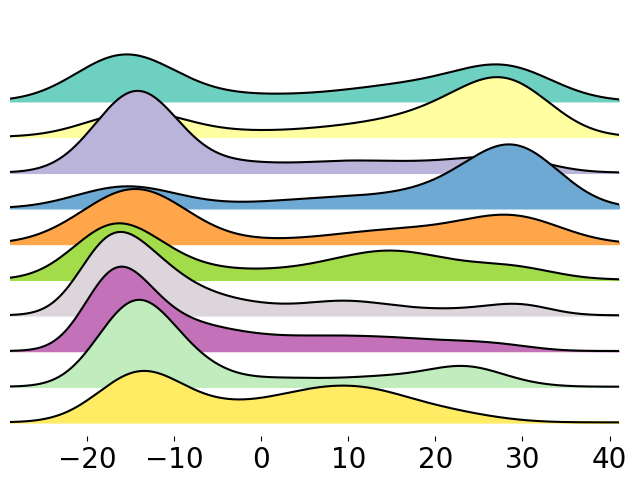

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy

custom4G1 = [(110/255, 208/255, 193/255),  # 1
            (255/255, 255/255, 162/255),  # 2
            (186/255, 179/255, 218/255),  # 3 
            (110/255, 169/255, 211/255),  # 4
            (255/255, 166/255, 74/255),   # 5
            (163/255, 220/255, 74/255),   # 6  
            (220/255, 213/255, 220/255),  # 7
            (195/255, 114/255, 186/255),  # 8
            (193/255, 237/255, 190/255),  # 9
            (255/255, 236/255, 100/255)]   # 10

# Sample data
df = [values_1, values_2, values_3, values_4, values_5, values_6, values_7, values_8, values_9, values_10]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

## Plot the mean G1 by atlas

In [139]:
from brainspace.utils.parcellation import reduce_by_labels
from brainspace.utils.parcellation import map_to_labels

# Parcelate cortical timeseries with BrainSpace
sG1_blades = reduce_by_labels(sG1, blades)

# Get the unique ROIs
unique_roi = np.unique(blades)

# Number of unique values
N_unique = len(unique_roi)

# Create an empty array with shape [ 'Number of time points' X 'ROIs' ]
sG1_blades = np.zeros([N_unique])


/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [140]:
# Get the mean value of the time series by ROI
for lab in range(N_unique):
    tmpData = sG1[blades == unique_roi[lab]]
    sG1_blades[lab] = np.nanmean(tmpData)
    del(tmpData)


/tmp/ipykernel_110998/4003035220.py:4: RuntimeWarning: Mean of empty slice
  sG1_blades[lab] = np.nanmean(tmpData)


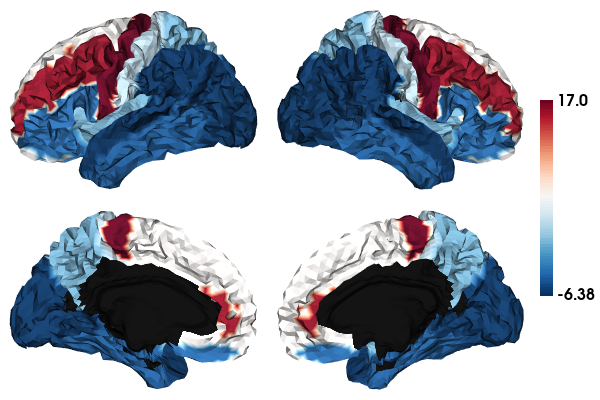

In [141]:
# Map back to surface fsLR-32k
sG1_blades_surf = map_to_labels(sG1_blades, blades)

# Plot of the mean of the parcellated timeseries on the surface
plot_hemispheres(MNI_wmL, MNI_wmR, array_name=sG1_blades_surf, size=(600, 400), zoom=1.6, embed_nb=True, 
                 interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='RdBu_r', transparent_bg=False, color_bar='right', layout_style='grid')

## Plot the G1 by quantile

In [50]:
q25 = np.nanquantile(sG1[mask_5k == True], 0.25)
q75 = np.nanquantile(sG1[mask_5k == True], 0.75)

In [51]:
G1_q25 = [1 if x <= q25 else 0 for x in sG1]
G1_q75 = [1 if x >= q75 else 0 for x in sG1]
G1_q50 = [1 if (x > q25) and (x < q75) else 0 for x in sG1]

In [59]:
G1_q25 = np.array(G1_q25)
G1_q75 = np.array(G1_q75)
G1_q50 = np.array(G1_q50)

In [63]:
np.save('/host/percy/local_raid/youngeun/myjupyter/array/G1_q25.npy', G1_q25)
np.save('/host/percy/local_raid/youngeun/myjupyter/array/G1_q75.npy', G1_q75)
np.save('/host/percy/local_raid/youngeun/myjupyter/array/G1_q50.npy', G1_q50)

In [61]:
test = G1_q25 + G1_q75 + G1_q50

In [62]:
test

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
custom4G1 = [(110/255, 208/255, 193/255),  # 1
             (255/255, 255/255, 162/255),  # 2
             (186/255, 179/255, 218/255),  # 3
             (110/255, 169/255, 211/255),  # 4
             (255/255, 166/255, 74/255),   # 5
             (163/255, 220/255, 74/255),   # 6
             (220/255, 213/255, 220/255),  # 7
             (195/255, 114/255, 186/255),  # 8
             (193/255, 237/255, 190/255),  # 9
             (255/255, 236/255, 100/255)]   # 10

_ = ridge([values_1, values_2, values_3, values_4, values_5, values_6, values_7,
          values_8, values_9, values_10], color=custom4G1)

## SWM MPC (T1map)

In [242]:
MPC_T1map = build_mpc(mean_T1map, mask_surf) # compute mMPC

# Calculate the gradients
Ngrad=5
MPC_all, grad_T1map = mpc_dm(MPC_T1map, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

/tmp/ipykernel_2057641/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


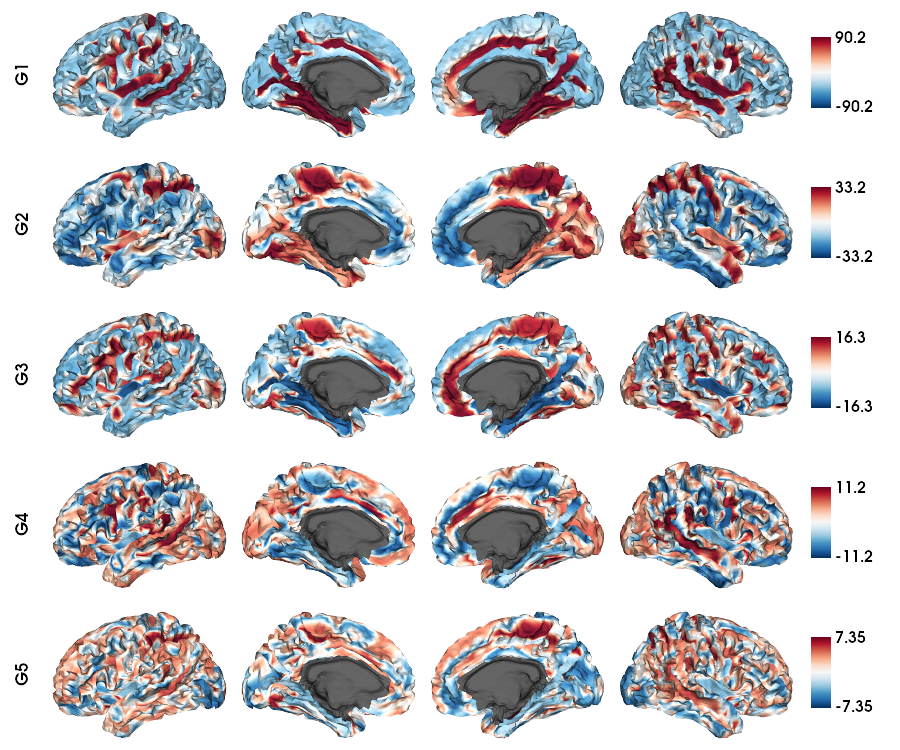

In [243]:
# Inflate the INFLATED surface 10% reference to the sphere
ws_lh, ws_rh = inflate_surf(MNI_wmL, MNI_wmR, sphere_lh, sphere_rh, W=0.1)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(ws_lh, ws_rh, array_name=grad_T1map, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## Cortical MPC (T1map)

In [260]:
def mpc_dm(MPC, mpc_mask, Ngrad=3, Smooth=False, kernel=None):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=0.9)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        if Smooth==True:
            grad[i] = smooth_surf(inf_lh, inf_rh, g_nan, mask_surf,Niter=3, Relax=0.35, Kernel='uniform')
        else:
            grad[i] = g_nan
    
    return(MPCgm, grad)

In [261]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# MPC files
cfile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]

cfile_paths = [f"sub-PNC0{name}/ses-03/mpc/acq-T1map/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii" for name in cfile_names]

cfiles_all = []
for cfile_path in cfile_paths:
    cfiles_all.extend(glob.glob(cfile_path))
    
# Load intensity profiles from each file
    profiles = []
    for cfile_path in cfiles_all:
        cprofile_data = nb.load(cfile_path).darrays[0].data
        profile_smooth = smooth_intensities(cprofile_data)
        profile_smooth[:, mask_5k == False] = np.nan
        profiles.append(profile_smooth)
    
    profiles = np.array(profiles)
    mean_cprofiles = np.mean(profiles, axis=0)

# make the MPC
cmpc_all = build_mpc(mean_cprofiles, mask_surf)

/tmp/ipykernel_2057641/2786603230.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


In [262]:
# Calculate the gradients
Ngrad=5
cMPC_all, cgrad = mpc_dm(cmpc_all, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

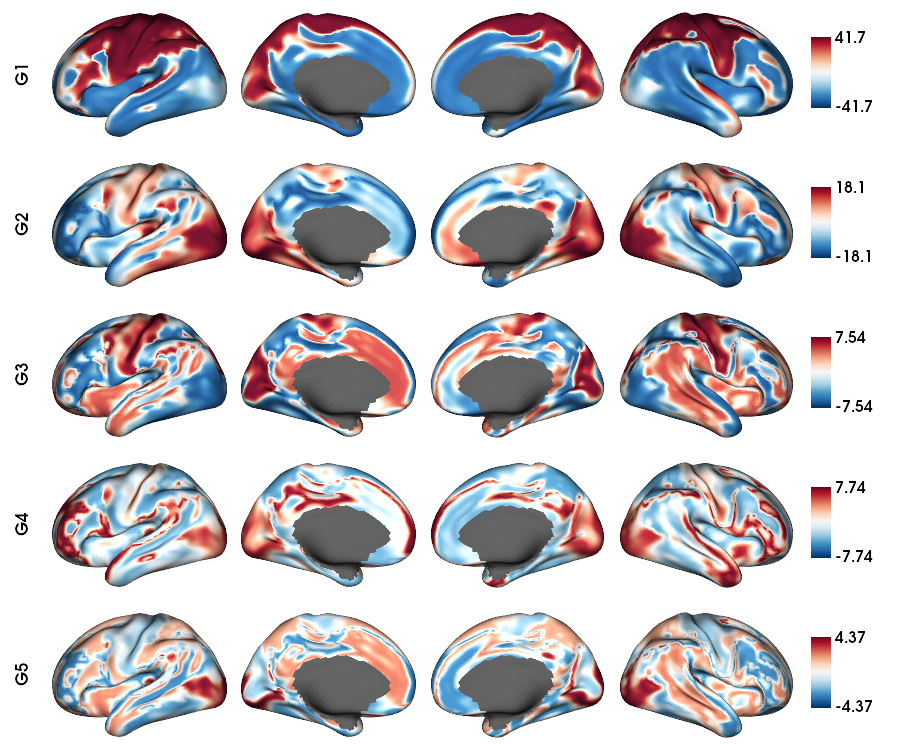

In [263]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=cgrad, cmap='RdBu_r', nan_color=(0.3, 0.3, 0.3, 1),
  zoom=1.5, size=(900, 150*Ngrad), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [264]:
row_cmeans = np.mean(mean_cprofiles, axis=0)

In [265]:
row_smeans = np.mean(mean_T1map, axis=0)

In [266]:
acgrad = row_cmeans[mask_5k == True]
agrad_T1map = row_smeans[mask_5k == True]
corr, p_value = spearmanr(acgrad, agrad_T1map)

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

Spearman correlation: 0.32555580166654624
P-value: 1.036039350405754e-217


In [268]:
filtered_T1map = mean_T1map[1:-1, :]
print(filtered_T1map.shape)

(14, 9684)


In [282]:
acprofiles = mean_cprofiles[:, mask_5k == True]
asprofiles = filtered_T1map[:, mask_5k == True]

reversed_cprofiles = acprofiles[::-1, :]
reversed_sprofiles = asprofiles[::-1, :]

In [283]:
spearman_correlations = np.zeros(14)
p_values = np.zeros(14)

for i in range(14):
    row1 = reversed_cprofiles[i, :]
    row2 = reversed_sprofiles[i, :]
    correlation, p_value = spearmanr(row1, row2)
    spearman_correlations[i] = correlation
    p_values[i] = p_value

for i in range(14):
    print(f"row {i+1}: Spearman correlation = {spearman_correlations[i]:.4f}, p-value = {p_values[i]:.30f}")

row 1: Spearman correlation = 0.4100, p-value = 0.000000000000000000000000000000
row 2: Spearman correlation = 0.3614, p-value = 0.000000000000000000000000000000
row 3: Spearman correlation = 0.3431, p-value = 0.000000000000000000000000000000
row 4: Spearman correlation = 0.3311, p-value = 0.000000000000000000000000000000
row 5: Spearman correlation = 0.3264, p-value = 0.000000000000000000000000000000
row 6: Spearman correlation = 0.3243, p-value = 0.000000000000000000000000000000
row 7: Spearman correlation = 0.3220, p-value = 0.000000000000000000000000000000
row 8: Spearman correlation = 0.3192, p-value = 0.000000000000000000000000000000
row 9: Spearman correlation = 0.3120, p-value = 0.000000000000000000000000000000
row 10: Spearman correlation = 0.2901, p-value = 0.000000000000000000000000000000
row 11: Spearman correlation = 0.2388, p-value = 0.000000000000000000000000000000
row 12: Spearman correlation = 0.1261, p-value = 0.000000000000000000000000000000
row 13: Spearman correlat

In [285]:
spearman_correlations = np.zeros(9684)
p_values = np.zeros(9684)

for i in range(9684):
    col1 = mean_cprofiles[:, i]
    col2 = filtered_T1map[:, i]
    correlation, p_value = spearmanr(col1, col2)
    spearman_correlations[i] = correlation
    p_values[i] = p_value

In [286]:
spearman_correlations.shape

(9684,)

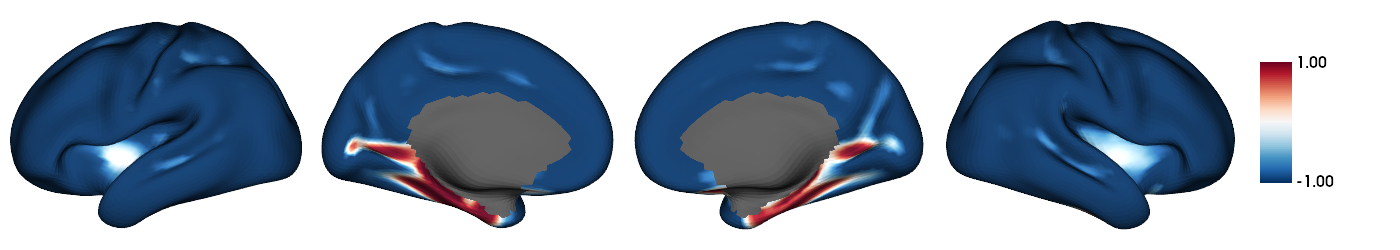

In [288]:
# plot labels on surface
plot_hemispheres(inf_lh, inf_rh, array_name=spearman_correlations, size=(1400, 250), zoom=1.5, embed_nb=True, interactive=False, share='both',
                 nan_color=(0.3, 0.3, 0.3, 1), cmap='RdBu_r', transparent_bg=True, color_bar='right')

In [289]:
spearman_correlations

array([-1., -1., -1., ..., -1., -1., -1.])

In [292]:
spearmanr(mean_cprofiles[:, i], filtered_T1map[:, i])

SignificanceResult(statistic=-1.0, pvalue=0.0)

In [295]:
# Find positions where NaN values exist
nan_indices = np.isnan(mean_cprofiles) | np.isnan(filtered_T1map)

# Arrays to store Pearson correlations and p-values
pearson_correlations = np.zeros(mean_cprofiles.shape[1])
p_values = np.zeros(mean_cprofiles.shape[1])

# Calculate Pearson correlation for each column
for i in range(mean_cprofiles.shape[1]):
    # Select only non-NaN data for correlation calculation
    valid_indices = ~nan_indices[:, i]
    col1 = mean_cprofiles[valid_indices, i]
    col2 = filtered_T1map[valid_indices, i]
    
    if len(col1) > 1 and len(col2) > 1:  # Calculate correlation if at least 2 data points are available
        correlation, p_value = pearsonr(col1, col2)
        pearson_correlations[i] = correlation
        p_values[i] = p_value
    else:
        pearson_correlations[i] = np.nan
        p_values[i] = np.nan

# Print the results
print("Pearson Correlations:", pearson_correlations)
print("P-values:", p_values)

Pearson Correlations: [-0.74113508 -0.74116732 -0.84889121 ... -0.89477609 -0.90252907
 -0.89585742]
P-values: [2.42114896e-03 2.41952612e-03 1.23107063e-04 ... 1.55661356e-05
 1.00059318e-05 1.46660588e-05]


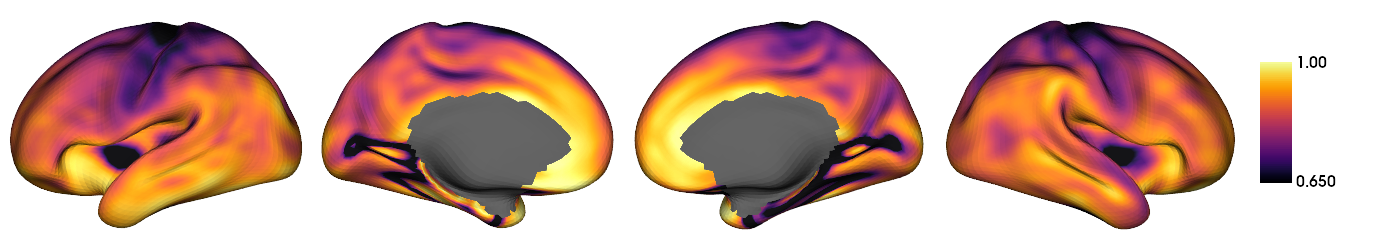

In [304]:
# plot labels on surface
plot_hemispheres(inf_lh, inf_rh, array_name=np.abs(pearson_correlations), size=(1400, 250), zoom=1.5, embed_nb=True, interactive=False, share='both',
                 nan_color=(0.3, 0.3, 0.3, 1), cmap='inferno', transparent_bg=True, color_bar='right', color_range=(0.65,1))

In [305]:
# plot labels on surface
plot_hemispheres(inf_lh, inf_rh, array_name=spearman_correlations, size=(1400, 250), zoom=1.5, embed_nb=True, interactive=False, share='both',
                 nan_color=(0.3, 0.3, 0.3, 1), cmap='RdBu_r', transparent_bg=True, color_bar='right')

nan

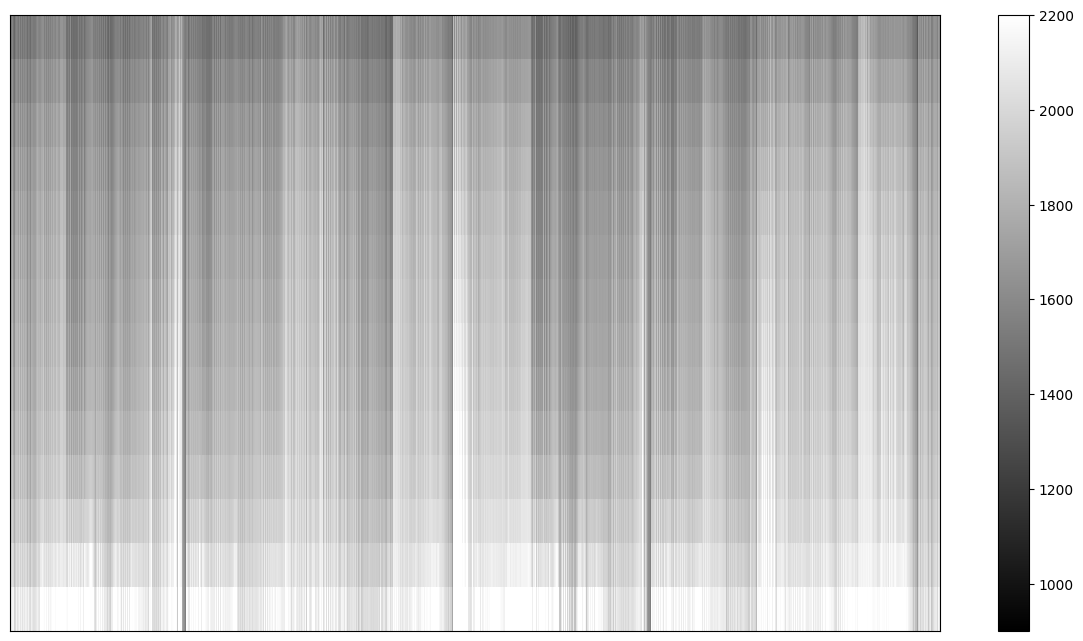

In [306]:
# Identify rows with NaN values and exclude them
data = mean_cprofiles
data[:, mask_5k == False] = np.nan
valid_rows = ~np.isnan(data).any(axis=0)
data_sliced = data[:, valid_rows]

# Adjust the figure size as per your requirement
plt.figure(figsize=(15, 8))  # Adjust the values (width, height) as needed

# COlor range
xlim = [900,2200]

# Plot the pcolormesh
pcm = plt.pcolormesh(data_sliced, cmap='gray', shading='auto', vmin = xlim[0], vmax = xlim[1])

# Set labels
#plt.xlabel('Vertices')
plt.xticks([])
plt.yticks([])  # Remove y-axis labels

cbar = plt.colorbar(pcm)

plt.show()

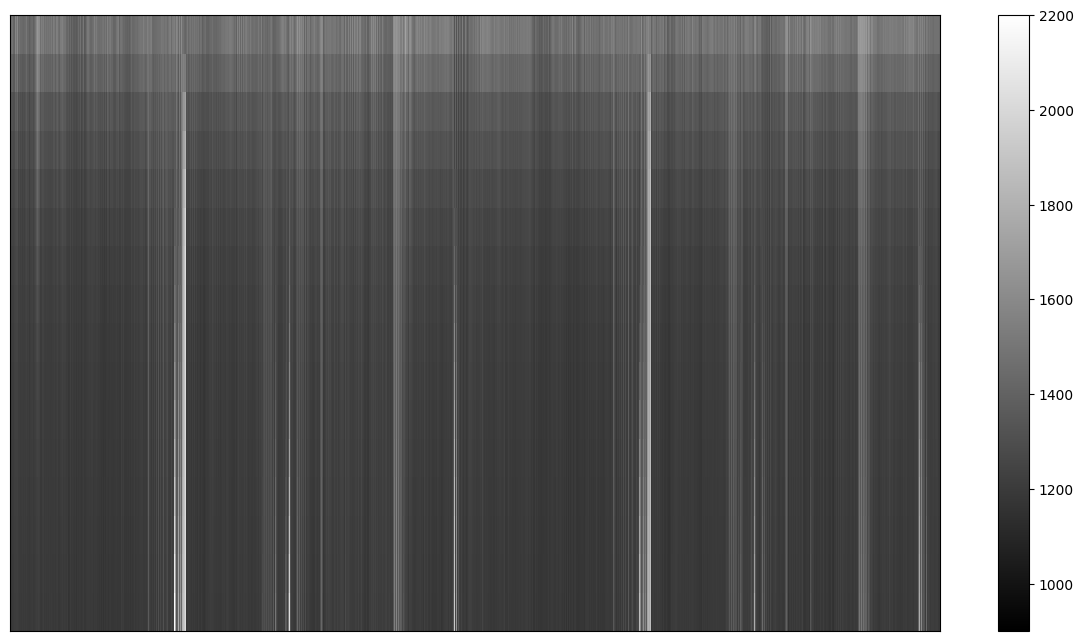

In [307]:
# Identify rows with NaN values and exclude them
data = mean_T1map
data[:, mask_5k == False] = np.nan
valid_rows = ~np.isnan(data).any(axis=0)
data_sliced = data[:, valid_rows]

# Adjust the figure size as per your requirement
plt.figure(figsize=(15, 8))  # Adjust the values (width, height) as needed

# COlor range
xlim = [900,2200]

# Plot the pcolormesh
pcm = plt.pcolormesh(data_sliced, cmap='gray', shading='auto', vmin = xlim[0], vmax = xlim[1])

# Set labels
#plt.xlabel('Vertices')
plt.xticks([])
plt.yticks([])  # Remove y-axis labels

cbar = plt.colorbar(pcm)

plt.show()